# Surviving the Sinking of the Titanic

## Problem Statement
We want to develop an algorithm that can look at the passenger data and help us predict the survival of those passengers.

## Logistic Regression
Rather than modelling the response Y (default) directly, logistic regression models the _probability_ that Y belongs  to a particular category. For this dataset, we'll use logistic regression to model the probability of passenger 'survival' given a host of predictor variables, $X$.

$$ \text{Pr}(\text{default} = \text{Yes | X})$$

The values of $p(\text{X})$ will range between 0 and 1. Then for any given value of X, a prediction can be made for survival. 

### The Logistic Model
Our aim is to use the linear regression equation:

$$ p(X) = \beta_0 + \beta_1\times X_1 + \beta_2\times X_2 + \ ... \ + \beta_n \times X_n$$

to model the probability of finding defaulters given their balance. To do this we must model $p(X)$ using a function that gives outputs between 0 and 1 for all values of X. Many functions meet this description. In logistic regression, we use the **logistic function**. 

$$p(X) = {1 \over {1 + e^{-\beta_0 + \beta_1X_1 + \ ...}}}= {e^{\beta_0 + \beta_1 X_1 + \ ...} \over {1 + e^{\beta_0 + \beta_1 X_1 + \ ...}}}$$

The logisitc function is also known as the **sigmoid function**. A sigmoid funtion has a characteristic S-shaped curve, which means it oscillates between 0 and 1. We can convert our linear equation values into a probability using a sigmoid function. These probability values can then be used to give us a 0 or 1 binary classification.

In [69]:
#Data and numerical computing libraries
import pandas as pd
import numpy as np

#Helper function for feature engineering and modelling
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization Libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Setting some default plotting options
mpl.style.use('seaborn')
sns.set_style('whitegrid')
sns.set_palette("cubehelix")
pylab.rcParams['figure.figsize'] = 12,8


In [70]:
#creating the logistic function
def sigmoid_logistic(x):
    '''
    Arguments:
        x -- Product of weight and input feature (or vector)
    Output:
        Returns the sigmoid of the product (vector)
    '''
    return np.exp(x)/(1 + np.exp(x))

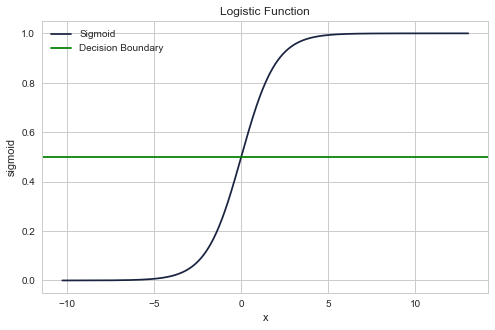

In [71]:
#Creating an array
x = np.random.normal(0,3,10000)
x.sort()
#Using the sigmoid on the array
z1 = sigmoid_logistic(x)
#Plot
f = plt.figure(figsize=(8,5))
plt.plot(x,z1)
plt.axhline(0.5, color = "green")
plt.legend(["Sigmoid","Decision Boundary"])
plt.xlabel("x")
plt.ylabel("sigmoid")
plt.title("Logistic Function")
plt.show()

After a bit of manipulation of the sigmoid function:
$${p(X) \over {1-p(X)}} = {e^{\beta_0 + \beta_1X}}$$

The quantity ${p(X) \over {1-p(X)}}$ is called the _odds_, and can take on any value between $0$ and $\infty$. Values of the odds close to 0 and ∞ indicate very low and very high probabilities of default, respectively.

By taking the logarithm of both sides:
$${\log{\large(}{p(X)\over{1-p(X)}}{\large)}} = \beta_0 + \beta_1X$$

The left hand side is called the _log-odds_ or **logit**. 

In linear regression, $\beta_1$ gives the average change in $Y$ associated with one unit increase in $X$. In logistic regression, increasing $X$ by one unit changes the logit by $\beta_1$, or equivalently it multiplies the odds by $e^{\beta_1}$. However, because the relationship between $p(X)$ and $X$ is not a straight line, $\beta_1$ does not correspond to the change in $p(X)$ associated with one unit increase in $X$. The amount that $p(X)$ changes due to a one-unit change in $X$ will depend on the current value of $X$. But regardless of the value of $X$, if $\beta_1$ is positive then increasing $X$ will be associated with increasing $p(X)$, and if $\beta_1$ is negative, then increasing $X$ will be associated with decreasing $p(X)$. 

### Let's Start with the Data!

Now there are many optimization algorithms for Logistic Regression. The most basic one is called **Maximum Liklihood Estimation** but we are not going to go into it right now. In fact, we'll use another optimization algorithm called **Gradient Descent**. But first, we'll start working with our data and use Python's machine learning libraries to model our data using Logistic Regression (we'll start by treating the optimization algorithm as black box).

In [72]:
#Loading in the data
train = pd.read_excel("data/titanic/train.xlsx")
test = pd.read_excel("data/titanic/test.xlsx")
#Let's combine them both into one dataset for now
data = pd.DataFrame.append(other = test, self= train)

Let's see what our data looks like!

In [73]:
print(f"Number of passengers in dataset: {len(data)}")

Number of passengers in dataset: 1782


In [74]:
#Let's take a glimpse at the data
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [75]:
#Let's see some summary statistics about the data
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1782.000000,1782.000000,1782.000000,1428.000000,1782.000000,1782.000000,1782.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.281582,0.486456,0.835836,14.521407,1.102434,0.805831,49.679476
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.250000,0.000000,2.000000,20.000000,0.000000,0.000000,7.903100
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.750000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Understanding our Independent and Dependent Variables

- _Survived_: This is obviously our dependent variable. We want to potentially use the rest of the data to accurately predict the surivival of the passengers.


- _PassengerID_ and _Ticket_ are random unique identifiers and we can assume that they will not have an impact on the survival rate of the passengers.


- _Pclass_: Stands for passenger class, it is an ordinal variable (has a hierarchy to the value) and we can assume that it represents the socio-economic class of the passenger. 


- _Sex_: Gender of the passenger, nominal (categorical) variable. We will one-hot-encode this during the modelling process.


- _Embarked_: Port from where the passenger boarded the Titanic. Categorical variable. Eg. C = Cherbourg, Q = Queenstown, S = Southampton


- _Age_ and _Fare_: Continous quantitative variables.


- _SibSp_ and _Parch_: Represents number of related siblings/spouse aboard and number of related parents/children aboard respectively.


- _Cabin_: Cabin number on the ship. Categorical variable.

## Data Wrangling

### Checking for null values

**Exercise 1**
Check if there are any null values present in the dataset.  
_Hint: Use the isnull function for pandas dataframes_

In [76]:
#Check for null values in any of the columns
data.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             354
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1374
Embarked          4
dtype: int64

**Output**
You should get the following table 

PassengerId       0  
Survived          0  
Pclass            0  
Name              0  
Sex               0  
Age             354  
SibSp             0  
Parch             0  
Ticket            0  
Fare              0  
Cabin          1374  
Embarked          4

We have quite a few missing values to deal with. Let's deal with all of them one by one. 

1. **Age**: In such a small dataset as this we cannot afford to not drop the missing rows and/or not use them in our analysis. The best way to go about this is to first see what kind of distribution Age is following. Most of the times variables like Age in a setting like the Titanic will follow the Normal Distribution, which means that most of the data will be centered around the mean (mean and median are the same in a Normal Distribution). 

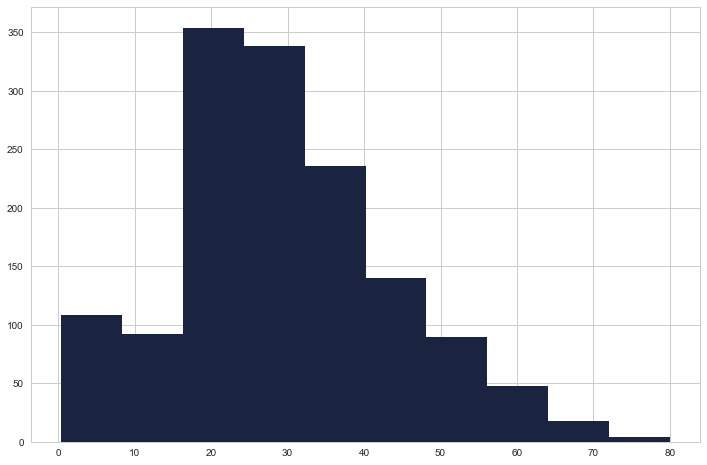

In [77]:
#Looking at the distribution of Age
data['Age'].hist()
plt.show()

As suspected, it is a normal distribution with a bit of a skew. Our mean and media should be nearly the same.

In [78]:
print(f"Mean Age on the Titanic: {data['Age'].mean()}\n\
Median Age on the Titanic: {data['Age'].median()}")

Mean Age on the Titanic: 29.69911764705882
Median Age on the Titanic: 28.0


We can use the median or rounded of mean to fill in the null values for Age.

2. **Cabin**: With almost 80% of the data missing for Cabin, this column is useless for our analysis and we can just drop it. 

3. **Embarked**: Only 4 missing rows. This is a categorical column so we can't use mean/median here but we can use mode. Mode is the most commonly occuring value.

**Exercise 2**  
1. Replace missing values for _Age_ with its median value.
2. Replace missing values for _Embarked_ with its mode.
3. Drop the column for _Cabin_, _PassengerID_, and _Ticket_

In [79]:
print(f"Most Common Value in Embarked: {data['Embarked'].mode()[0]}")

Most Common Value in Embarked: S


In [80]:
#Replace NaN values

#Age
data['Age'].fillna(data['Age'].median(), inplace = True)

#Embarked
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)

#Drop Cabin, PassengerID, and Ticket
drop_column = ['PassengerId','Cabin', 'Ticket']
data.drop(drop_column, axis=1, inplace = True)

Let's check how the null situation looks like now.

In [81]:
data.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

### Feature Engineering and Exploratory Analaysis
Let's have a look at all our predictors and see how they play with eachother, what kind of information we can get from them and if we can infer some new features out of them.

**Exercise 3**  
Examine the rate of survival based on Pclass, Sex, and Embarked

In [82]:
#Group the dependent variable survived based on Pclass
data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [83]:
#Now group the dependented variable survived based on both Pclass and Sex 
data[['Pclass', 'Sex','Survived']].groupby(['Pclass','Sex'], as_index=False).mean()

,Pclass,Sex,Survived
0,1,female,0.968085
1,1,male,0.368852
2,2,female,0.921053
3,2,male,0.157407
4,3,female,0.500000
5,3,male,0.135447


Looking at this distribution it seems that the passengers who were economically better off had a higher chance of survival. Drilling down on the passengers by gender we see that in every passenger class group, female passengers had a much higher chance of survival than male.

In [84]:
#Group the rate of survival based on Sex
data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


Female passengers had a much better chance at survival than male.

In [85]:
#Group rate of survival based on Embarked
data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


Strangely, people who boarded from Cherbourg had a better rate of survival than the other two ports. We'll examine this later on.

**Exercise 4**  
Let's now try and find information about survival based on Age, Fare, and the number of siblings/parents with each passenger. We'll have to modify our approach a little bit for this. 
1. We can group different ages/fares together into categories and then check the survival rate for those categories.
2. After grouping passengers based on age group, try and see if gender is a good variable get more granular with the division.
3. Similarly, we can use the information we have about siblings/parents and create a new feature called _'FamilySize'_ and then check the survival rate for FamilySize. Based on this approach we can also see if a passenger is travelling alone and create a new feature for that as well. 
4. Group the data by different Fare prices and check the difference in survival rates.

_Hint: Remember that when creating family size, add 1 to include the passenger themselves._

In [86]:
#Let's start with Age

#Create a new column for age group on the basis of the following divisions
# <= 14 - Child
# <= 18 - Adolscent
# <= 40 - Adult
# <= 60 - Middle Aged
# > 60 - Elderly

#Precise way to do it
data['AgeGroup'] = np.where(data['Age'] <= 13, 'Child', 
                   (np.where(data['Age'] <= 18, "Adolescent", \
                    np.where(data['Age'] <= 40, "Adult", \
                    np.where(data['Age'] <= 60, "Middle Aged", "Elderly")))))
data[['AgeGroup','Survived']].groupby(['AgeGroup'], as_index=False).mean()

,AgeGroup,Survived
0,Adolescent,0.411765
1,Adult,0.360465
2,Child,0.591549
3,Elderly,0.227273
4,Middle Aged,0.390625


We see from this that the best chances of survival was with the very young and the worst with the elderly. This makes sense because children wouldve been looked after by their parents, siblings and other adults and would have been the first to be loaded onto rafts and boats.

Let's see if we drill down by gender then what changes do we see.

In [87]:
#Group the data together by AgeGroup and Sex
data[['AgeGroup','Sex','Survived']].groupby(['AgeGroup','Sex'], as_index=False).mean()

,AgeGroup,Sex,Survived
0,Adolescent,female,0.735294
1,Adolescent,male,0.088235
2,Adult,female,0.757576
3,Adult,male,0.165842
4,Child,female,0.617647
5,Child,male,0.567568
6,Elderly,female,1.000000
7,Elderly,male,0.105263
8,Middle Aged,female,0.755556
9,Middle Aged,male,0.192771


Again, we see that gender played a big role in determining survival rate. Chivalry was not dead a 100 years ago and the old adage of "Women and Children first" rang true in the case of the Titanic. Almost at every level, except children, the difference between survival rate for female passengers and male passengers is astronomical. 

In [88]:
#Now let's create the vector for FamilySize

data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data[['FamilySize','Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [89]:
#Isolate passengers who travelling alone and measure survival rates
data['isAlone'] = np.where(data['FamilySize'] == 1, 1, 0)
data[['isAlone','Survived']].groupby(['isAlone'], as_index=False).mean()

,isAlone,Survived
0,0,0.505650
1,1,0.303538


In [90]:
#Further group survival rate by lone passengers and gender
data[['isAlone','Sex','Survived']].groupby(['isAlone','Sex'], as_index=False).mean()

,isAlone,Sex,Survived
0,0,female,0.712766
1,0,male,0.271084
2,1,female,0.785714
3,1,male,0.155718


1. Large family sizes had a poorer rate of survival than mid-sized families.  
2. Best rate of survival seems to be in a family of 4.  
3. Passengers travelling alone had a lower rate at survival than passengers travelling with family.
4. Even in alone passengers, female travellers had a much higher survival rate than male travellers.

In [91]:
#We'll use the data for fare cut by 4 quarters 
data['Fare'].describe()

count    1782.000000
mean       32.204208
std        49.679476
min         0.000000
25%         7.903100
50%        14.454200
75%        31.000000
max       512.329200
Name: Fare, dtype: float64

In [92]:
#Grouping by survival rate
data['FareCategory'] = np.where(data['Fare'] <= 7, "Cheap", 
                   (np.where(data['Fare'] <= 14,  "Lower-Mid", \
                    np.where(data['Fare'] <= 31, "Upper-Mid", "High"))))


data[['FareCategory','Survived']].groupby(['FareCategory'], as_index=False).mean()

,FareCategory,Survived
0,Cheap,0.071429
1,High,0.581081
2,Lower-Mid,0.266504
3,Upper-Mid,0.439655


The only feature we havent really fiddled with is the Name of the passenger. Generally, that would not provide us much information to use but in this case, all the names are appended with a title. Perhaps we can extract some information from the titles of our passengers.

In [93]:
#Library for regular expressions
import re

#Function to use a regular expression to find titles from names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

#applying the function to the Name column
data['Title'] = data['Name'].apply(get_title)

#looking at the distribution for titles cut by gender
pd.crosstab(data['Title'], data['Sex'])


Sex,female,male
Title,,
Capt,0,2
Col,0,4
Countess,2,0
Don,0,2
Dr,2,12
Jonkheer,0,2
Lady,2,0
Major,0,4
Master,0,80


Let's categorize all these titles into broader groups.

In [94]:
#Group together uncommon titles into one category
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

#Replacing the title abberations in titles
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

#Group survival rate by title
data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Other,0.347826


While most of this information was known to us through the use of age groups and gender, we have managed to get an additional feature for 'Other' titles and the fact that they add on to the rate of survival.

### Encoding the data

With so many categorical variables, we will need to encode them so that we can use them in our predictive model. First we'll encode the text categories into numerical categories and then we will use one-hot-encoding to 

In [95]:
#Create a copy of the dataset
data_original = data.copy()

#Encode the column for Sex (female:0, male:1)
gender_mapping = {"female":0,"male":1}
data['Sex'] = data['Sex'].map( gender_mapping ).astype(int)

#Encode the column for AgeGroup
age_mapping = {"Child":0,"Adolescent":1,"Adult":2,"Middle Aged":3,"Elderly":4}
data['AgeGroup'] = data['AgeGroup'].map( age_mapping ).astype(int)

#Encode the column for titles 
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
data['Title'] = data['Title'].map(title_mapping).astype(int)
data['Title'] = data['Title'].fillna(0)

#Encode the column for Embarked
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
data['Embarked'] = data['Embarked'].map(embarked_mapping).astype(int)

#Changing data type of Fare and Age to integer
fare_mapping = {"Cheap":0,"Lower-Mid":1,"Upper-Mid":2,"High":3}
data['FareCategory'] = data['FareCategory'].map(fare_mapping).astype(int)


In [96]:
#Peeking at our dataset
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,FamilySize,isAlone,FareCategory,Title
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,0,2,2,0,1,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,1,2,2,0,3,3
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,0,2,1,1,1,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,0,2,2,0,3,3
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,0,2,1,1,1,1


### Feature Selection

Let's drop the columns we no longer need.

In [97]:
#List of columns to drop
drop_elements = ['Name','SibSp','Parch','Age','Fare']
#Drop columns
data.drop(drop_elements, axis = 1, inplace=True)

#peeking at our dataset
data.head()

,Survived,Pclass,Sex,Embarked,AgeGroup,FamilySize,isAlone,FareCategory,Title
0,0,3,1,0,2,2,0,1,1
1,1,1,0,1,2,2,0,3,3
2,1,3,0,0,2,1,1,1,2
3,1,1,0,0,2,2,0,3,3
4,0,3,1,0,2,1,1,1,1


Let's do some exploratory analysis and get some descriptive statistics and graphs out of the data.

**Exercise 5**  
Write code to find the correlation between every category amongst the predictor variables and the response variable.

Eg.   
Predictor Variable: Pclass  
Correlation Coefficients with Response Variable (Survived):  
{1: 0.62, 2: 0.47, 3: 0.24}

In [98]:
#Find the correlation between between different categories amongst our predictor variables
for x in data.columns.tolist()[1:]:
    if data[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(data[[x, ['Survived'][0]]].groupby(x, as_index=False).mean())
        print('-'*50, '\n')


Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
-------------------------------------------------- 

Survival Correlation by: Sex
   Sex  Survived
0    0  0.742038
1    1  0.188908
-------------------------------------------------- 

Survival Correlation by: Embarked
   Embarked  Survived
0         0  0.339009
1         1  0.553571
2         2  0.389610
-------------------------------------------------- 

Survival Correlation by: AgeGroup
   AgeGroup  Survived
0         0  0.591549
1         1  0.411765
2         2  0.360465
3         3  0.390625
4         4  0.227273
-------------------------------------------------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
--------------------------------

Here's a correlation heatmap for the data

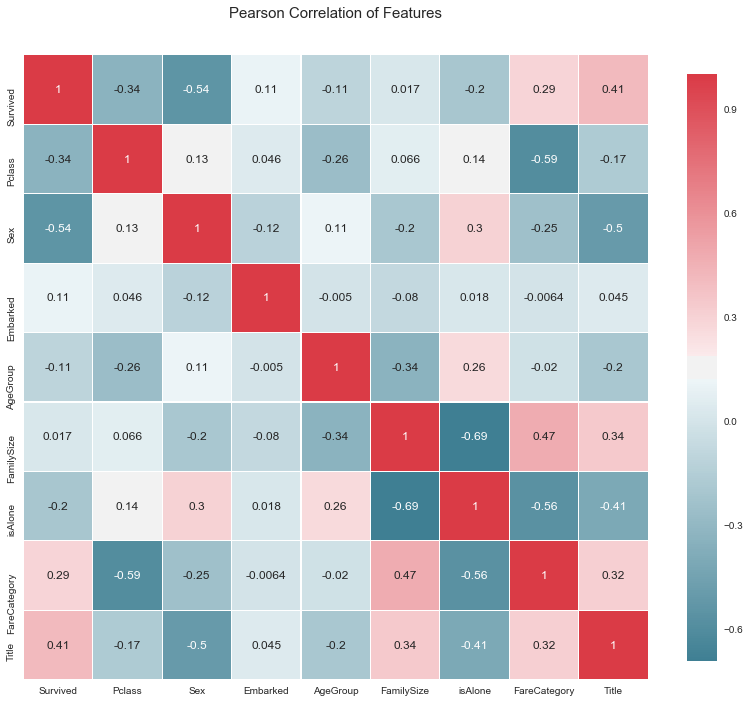

In [99]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data)


### One Hot Encoding
Machine Learning Algorithms dont understand classes like we do. There is a risk our integer encoding for categorical variables can be misinterpreted in a way that a higher integer is more important. For example, both genders should be percieved as equal but due to male being 1 and female being 0, there is a risk that more weight is allocated to the male geneder during analysis. For this we do one hot encoding. This will create an additional column for each row&mdash;one for female with a binary response of 0 or 1 and one for male with a binary response for 0 or 1. We will do this encoding for all our categorical variables:

- Sex
- Embarked
- AgeGroup
- FamilySize
- isAlone
- Title


We are not doing this encoding for ordinal variables like Pclass and FareCategory because there is an order to them.

In [100]:
#At this point, let's create another copy of our data
data_encoded = data.copy()

#one hot encoding
data = pd.get_dummies(data, columns=["Sex","Embarked","AgeGroup","FamilySize","isAlone","Title"], \
                         prefix=["Sex", "Embarked", "AgeGroup","FamilySize","isAlone","Title"])


#taking a peek
data.head()

,Survived,Pclass,FareCategory,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,AgeGroup_0,AgeGroup_1,...,FamilySize_7,FamilySize_8,FamilySize_11,isAlone_0,isAlone_1,Title_1,Title_2,Title_3,Title_4,Title_5
0,0,3,1,0,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,1,1,3,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,1,1,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,1,1,3,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,3,1,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


We have a total of 1782 passengers on the titanic. Let's restructure our training and test sets, we'll allocate approximately 80% passengers to our training set and 20% to our test set.

#### Exercise 6:  
Split the data into _training_ and _test_ sets.

In [102]:
from sklearn.cross_validation import train_test_split
#Extract the features into a variable X [numpy array] and the dependent variable into y [numpy array]
X = data.iloc[:,1:].values
y = data.iloc[:,0].values

#Split dataset into train, validation, test
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=1)

print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}\n\
Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")

Shape of X_train: (1425, 28), Shape of y_train: (1425,)
Shape of X_test: (357, 28), Shape of y_test: (357,)


**Output**:  
Shape of X_train: (1425,28), Shape of y_train: (1425,)  
Shape of X_test: (257, 28), Shape of y_test: (357,)

### Model
Let's begin with using sci-kit learn to just directly put our data into a logistic regression model and see our results.

In [103]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Scikit Logistic Regression
scikit_log_reg = LogisticRegression(penalty="l2")
scikit_log_reg.fit(X_train,y_train)

#Score is Mean Accuracy
scikit_score = scikit_log_reg.score(X_test,y_test)
print(f'Accuracy: {round(scikit_score*100,2)}%')

Accuracy: 80.11%


### Evaluation

Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset. Calculating some other performance metrics can give us a better idea about how our classification model has performed.

- _Accuracy_: Out of all our predictions, what percentage were correct. 
- _True Positives_: Out of all the people we predicted will survive, how many actually survived.  
- _False Positives_: Out of all the people we predicted will survive, how many did not survive.  
- _False Negatives_: Out of all the people we predicted will not survive, how many actually survived.
- _True Negatives_: Out of all the people we predicted will not survive, how many actually did not survive.


- _Recall_: Out of all the people who survived, what percentage did we predict will survive.   

    $$ Recall = {TP \over {TP + FN}}$$
    
    
- _Precision_: Out of all the people we predicted have survived, what percentage actually survived.  

    $$ Precision = {TP \over {TP + FP}}$$
    
    
- _$F_1$ Score_: In binary statistical analysis, the F score is used as a measure to convey the balance between precision and recall. An $F_1$ score reaches it's best value at 1 (perfect precision and recall) and worst at 0.

    $$ F_1 = 2  \times  {{precision \times recall}\over{precision + recall}}$$
    
    
- _Confusion Matrix_: A confusion matrix is a technique for summarizing the performance of a classification algorithm.


**Exercise 7**
Calculate:  
1. Precision
2. Recall
3. $F_1$ Score

In [104]:
#Let's use our Logistic Regression Model to get an array of predictions
predictions = scikit_log_reg.predict(X_test)

#Function to calculate Precision and Recall
def precision_recall_f1(y_pred, y):
    #Simpler:
#     tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0


    for i in range(len(y)):
        
        if y_pred[i] == y[i] == 1:
            TP += 1
        elif y_pred[i] == y[i] == 0:
            TN += 1
        elif y_pred[i] == 1 and y[i] != 1:
            FP += 1
        elif y_pred[i] == 0 and y[i] != 0:
            FN += 1
        else:
            raise ValueError(f"Incorrect value in data. {y_pred[i]}, {y[i]}")
        
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*((precision*recall)/(precision+recall))
        
    return {"Precision":precision, "Recall":recall, "F1":f1}

scores = precision_recall_f1(predictions,y_test)
print(f"Precision: {scores['Precision']}\n\
Recall: {scores['Recall']}\n\
F1: {scores['F1']}")

Precision: 0.7923076923076923
Recall: 0.7006802721088435
F1: 0.743682310469314


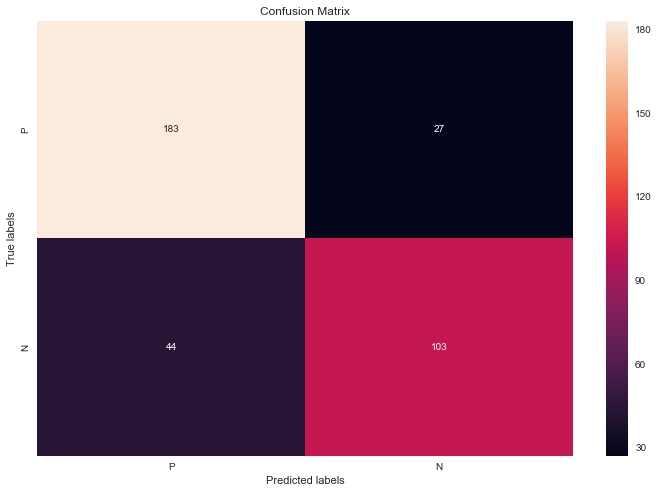

In [105]:
#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
cm = confusion_matrix(y_test, predictions)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="g"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['P', 'N']); ax.yaxis.set_ticklabels(['P', 'N']);


## Gradient Descent
Let's look at another way to model the data using Logistic Regression. But this time, we'll code in the optimization algorithm ourselves using an optimization algorithm called Gradient Descent.

### What is a Gradient? 
A gradient is a fancy word for a derivative. And a derivative is the rate of change of a function. It is a vector that:
- Points in the direction of the greatest increase of a function.
- Is zero at a local maximum or minimum (because there is no single direction of increase).

Now, just like Linear Regression, we want the best weights and biases (slope and intercept terms) which help us have the least distance for the correct class and the most distance for the incorrect class.

For that we measure the loss:
$$ L = {{1 \over {N}} \sum_i D(S(wx_i + b), L_i)}$$
Here, $S$ is our prediction vector and $L_i$ are the actual labels.

Our aim is to minimize this function. One of the simplest and best way to minimize the loss is **Gradient Descent**. Take the derivative of your loss with respect to your parameters and follow that derivative by taking a step backward and repeat until you are at the minima.

### Hill Climbing
Let's break down gradient descent outside of the technical talk. Imagine you're walking in a hilly region, and you need to get down from the hills towards a valley. You dont really care that much which valley you get down to&mdash;although you'd prefer the valley at the very bottom&mdash;but you'll make do with any valley. Unfortunately, you're blind and you cant visually see where the vallies are located. But you can _feel_ whether you're going up or down. 

Now let's say you're standing at a random position in this hilly area and you take a step in one direction. Also assume that you have superpowers so you can take _really long_ steps. You want to make sure the steps you take are not _too small_, in which case you'll take years to reach the valley. But they shouldnt be _too large_ either, othewise you'd end up walking over a valley and not realize it (like I said, you can take _really_ large steps if you want). So you'd better be wise about your definition of your _step taking rate_&mdash;or in machine learning parlance: **learning rate**.

Right, so you take a step and you _feel_ you've come down a little bit from the earlier position you were at. In machine learning terms, you will _feel_ you've come down when you measure you're performance using the **loss function**. If the loss function has come down from the previous step, then it means you're going in the right direction. At this point, you will take the gradient of the loss function and update your original weights and biases. 

Now you take another step from the updated position! And so on and so forth you continue for **n iterations** _or_ till you reach a valley. If you reach a valley, the gradient will keep oscillating within that valley and you will not go further down.

<img src ="images/gradient_descent.png">

Let's get to work to find the right linear combination of weights and inputs which will help us classify these two types of iris plants correctly.

In [121]:
#Let's start by creating a function to initialize the weights
#For our first attempt let's initialize the weights to 0
def initialize_weights(features, random = True):
    '''
    Arguments:
        features -- input matrix (n x m) for our feature set
    Output:
        Returns a zero vector of shape (m x 1)
    '''
    if random == True:
#         theta = np.random.rand(features.shape[1]).reshape(features.shape[1],1)
        theta = np.random.normal(0,1, size = features.shape[1]).reshape(features.shape[1],1)
    elif random == False:
        theta = np.zeros(features.shape[1]).reshape(features.shape[1],1)
    return theta

#Let's add in the intercept terms to our input matrix.
#The intercept term is the garbage collector of our model.
#It accounts for any bias that is not accounted for by the terms in the model.
def add_intercept(features):
    '''
    Arguments:
        features -- input matrix (n x m) for our feature set
    Output:
        Returns an input matrix of shape (n x m+1) with a column
        of 1's appended to the matrix
    '''
    intercept = np.ones((features.shape[0],1))
    return np.concatenate((intercept, features), axis = 1)

#Adding the intercept term
X_ = add_intercept(X)
#Initializing the weights matrix
theta_ = initialize_weights(X_, random=False)

#Let's look at the shapes of our input matrix X and
#our weights matrix theta
print(f"Shape of Input Matrix X: {X_.shape}")
print(f"Shape of Weights Matrix theta: {theta_.shape}")


Shape of Input Matrix X: (1782, 29)
Shape of Weights Matrix theta: (29, 1)


Now, let's creat the predict function. It will find the dot product between the weights matrix and the input matrix and then use the sigmoid function to find the probability of each input row of being part of class 1 or 0.

In [156]:
def predict(features, weights):
    '''
    Returns 1 dimensional array of probabilities
    for class label == 1
    '''    
    z = np.dot(features, weights)
    return sigmoid_logistic(z)

#Let's test it and see what we get
predictions_ = predict(X_,theta_)
print(f"Shape of predictions: {predictions_.shape}")

#Let's test it and see what we get
np.random.seed(420)
b = np.random.randn(3,3)
w = np.random.normal(0,1,(3,1))
predictions_ = predict(b,w)
print(predictions_)

Shape of predictions: (1782, 1)
[[0.74056795]
 [0.18281486]
 [0.14084556]]


### Cost Function

The cost funtion is used to identify how good our prediction for a certain sample or a set of samples actually is when compared with the correct classifications. Our prediction is non-linear due to the sigmoid function, hence, we cannot use the L2 loss function. Instead we use the **Cross-Entropy** (also known as Log Loss) function. It can be thought of as a combination of two separate loss functions, one for $y=1$ and one for $y=0$.
Cost of a single example:
<table><tr><td width = "80%">
$$L_{cost} = {-y\log{1\over{1+e^{-\theta^{T}x}}}} - {(1-y)\log{1-{1\over{1+e^{-\theta^T x}}}}}$$</td><td>	$$\begin{cases}
            \text{if } y=1, \text{we want } \theta^T x &gt;&gt; 0 \\
            \text{if } y=0, \text{we want } \theta^T x &lt;&lt; 0
            \end{cases}$$</td></tr>
            
</table>

Total Cost:
$$J(\theta) = min_\theta {1\over{m}} \Bigl [ \sum^m_{i=1} y^{(i)} (-log \ h_\theta(x^{(i)})) + (1-y^{(i)}) \ ((-log(1-h_\theta(x^{(i)}))) \Bigr ] + {\lambda\over{2m}} \ {{\sum^n_{i=1} \theta^2_j}} $$
$$\text{where } \lambda \text{ is the regularization parameter}$$

The benefits of using these loss functions is revealed when we look at their graphs.


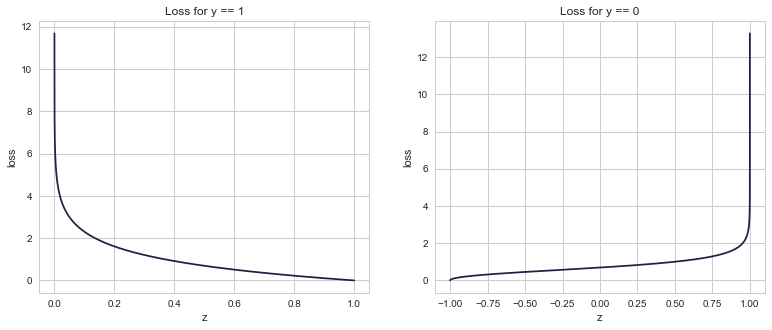

In [125]:
#Defining the loss function for y == 1
def loss_y1(x): return -np.log(x)
#Defining the loss function for y == 0
def loss_y2(x): return -np.log(1-x)

#Calculating the loss
a1_loss = loss_y1(z1)
a2_loss = loss_y2(z1)

#Plot
f = plt.figure(figsize=(13,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(z1,a1_loss)
ax1.set_xlabel("z")
ax1.set_ylabel("loss")
ax2.plot(z2,a2_loss)
ax2.set_xlabel("z")
ax2.set_ylabel("loss")
ax1.set_title("Loss for y == 1")
ax2.set_title("Loss for y == 0")
plt.show()


These smooth monotonic functions (always increasing or decreasing) make it easy to calculate the gradient and minimize cost.


In [161]:
#The loss/cost function
def cost_function(features, labels, weights, reg):
    '''
    Using Mean Absolute Error

    Features:(m,n)
    Labels: (m,1)
    Weights:(n,1)
    Returns 1D matrix of predictions
    Cost = ( log(predictions) + (1-labels)*log(1-predictions) ) / len(labels)
    '''
    observations = len(labels)

    predictions = predict(features, weights)

    #Take the error when label=1
    class1_cost = -labels*np.log(predictions)

    #Take the error when label=0
    class2_cost = (1-labels)*-np.log(1-predictions)

    regularization_term = reg/(2*observations) * np.sum(np.square(weights))
    #Take the sum of both costs
    cost = class1_cost + class2_cost + regularization_term

    #Take the average cost
    cost = cost.sum()/observations

    return cost

#Let's test it and see what we get
np.random.seed(420)
b = np.random.randn(3,3)
w = np.random.normal(0,1,(3,1))
p = np.array([0,1,0])
print(f"Cost of one iteration: {cost_function(b,p,w,0.1)}")


Cost of one iteration: 2.655157288371231


### Learning Rate
The size of these steps is called the learning rate. With a high learning rate we can cover more ground each step, but we risk overshooting the lowest point since the slope of the hill is constantly changing. With a very low learning rate, we can confidently move in the direction of the negative gradient since we are recalculating it so frequently. A low learning rate is more precise, but calculating the gradient is time-consuming, so it will take us a very long time to get to the bottom.
$$ {\delta{J(\theta)}\over{\delta\theta_j}} = {1\over{m}} \ X^T (g(X\theta) - y)$$
where:  
m -- number of observations  
X -- feature vector  
y -- labels  
$\theta$ -- weights  
g(X$\theta$) -- predictions  


In [166]:
#Gradient Descent
def update_weights(features, labels, weights, lr):
    '''
    Vectorized Gradient Descent

    Features:(200, 3)
    Labels: (200, 1)
    Weights:(3, 1)
    '''
    N = len(features)

    # Get Predictions
    predictions = predict(features, weights)

    # Transpose features from (n, m) to (m, n)
    # So we can multiply w the (n,1)  cost matrix.
    # Returns a (m,1) matrix holding m partial derivatives --
    # one for each feature -- representing the aggregate
    # slope of the cost function across all observations
    gradient = np.dot(features.T,  predictions - labels)

    # Take the average cost derivative for each feature
    gradient /= N

    # Multiply the gradient by our learning rate
    gradient *= lr

    # Subtract from our weights to minimize cost
    weights -= gradient

    return weights

#Let's test it and see what we get
np.random.seed(420)
b = np.random.randn(3,5)
w = np.random.normal(0,1,(5,1))
p = np.array([0,1,0]).reshape(-1,1)
learning_rate = 0.01

print(update_weights(b,p,w,learning_rate))


[[ 0.38277304]
 [-0.69288939]
 [ 0.71153   ]
 [-0.34105048]
 [ 1.54394326]]


In [128]:
#Creating the decision boundary
def decision_boundary(prob):
    return 1 if prob > 0.5 else 0

#Converting probabilities to classes 
def classify(preds):
    '''
    input - N element array of predictions between 0 and 1
    output - N element array of 0's (false) and 1's (true)
    '''
    #referencing our decision boundary function
    db = np.vectorize(decision_boundary)
    return db(preds).flatten()

#Example output
predictions_ = predict(X_,theta_)
classifications = classify(predictions_)
classifications


array([0, 0, 0, ..., 0, 0, 0])

iteration: 0, cost: 0.6896641803393098
iteration: 1000, cost: 0.4544596337859657
iteration: 2000, cost: 0.43627060387516226
iteration: 3000, cost: 0.4277238415891221
iteration: 4000, cost: 0.42171423585590506
iteration: 5000, cost: 0.4169959987009425
iteration: 6000, cost: 0.4131514306335094
iteration: 7000, cost: 0.4099610798475622
iteration: 8000, cost: 0.4072798209279437
iteration: 9000, cost: 0.40500246656820754
iteration: 10000, cost: 0.4030499036175307
iteration: 11000, cost: 0.40136147754647233
iteration: 12000, cost: 0.39989005588559196
iteration: 13000, cost: 0.39859859644806866
iteration: 14000, cost: 0.39745768683518545
iteration: 15000, cost: 0.3964437490882137
iteration: 16000, cost: 0.39553771252351605
iteration: 17000, cost: 0.39472402163415465
iteration: 18000, cost: 0.39398988688403414
iteration: 19000, cost: 0.39332471355850224
iteration: 20000, cost: 0.39271966248329687
iteration: 21000, cost: 0.392167309335493
iteration: 22000, cost: 0.3916613783232318
iteration: 23

iteration: 187000, cost: 0.3823657460043396
iteration: 188000, cost: 0.3823585761814551
iteration: 189000, cost: 0.38235146836140094
iteration: 190000, cost: 0.3823444216757287
iteration: 191000, cost: 0.38233743527388325
iteration: 192000, cost: 0.3823305083227054
iteration: 193000, cost: 0.3823236400059497
iteration: 194000, cost: 0.3823168295238199
iteration: 195000, cost: 0.3823100760925195
iteration: 196000, cost: 0.3823033789438186
iteration: 197000, cost: 0.382296737324635
iteration: 198000, cost: 0.38229015049662896
iteration: 199000, cost: 0.38228361773581254


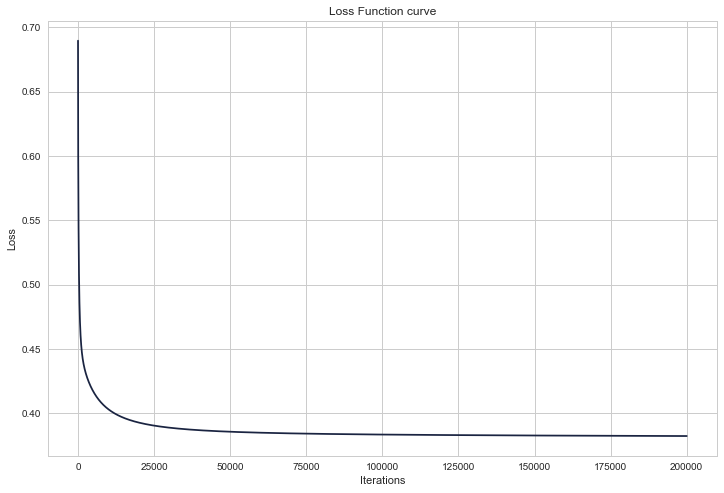

In [135]:
#Training code
def train(features, labels, lr, iters, reg):
    cost_history = []
    #Add intercept term to features
    features = add_intercept(features)
    #Initialize weights
    weights = initialize_weights(features,random=False)
    for i in range(iters):
        weights = update_weights(features, labels, weights, lr)
        
        #Calculate error
        cost = cost_function(features, labels, weights,reg)
        cost_history.append(cost)
        
        #Log progress
        if i%1000 == 0:
            print(f"iteration: {i}, cost: {cost}")
    
    plt.plot(list(range(iters)), cost_history)
    plt.title("Loss Function curve")
    plt.xlabel("Iterations"); plt.ylabel("Loss")
    plt.show()
    return weights, cost_history

W, cost_history = train(X_train, y_train.reshape(-1,1), lr = 0.01, iters = 100000, reg = 0)


In [136]:
#Accuracy
def accuracy(predicted_labels, actual_labels):
    diff = predicted_labels - actual_labels
    return 1.0 - (float(np.count_nonzero(diff)) / len(diff))

predictions = classify(predict(add_intercept(X_test),W))
print(f"Accuracy of our classifier: {round(accuracy(predictions.reshape(predictions.shape[0],1),y_test.reshape(-1,1)),5)*100}%")


Accuracy of our classifier: 80.11200000000001%


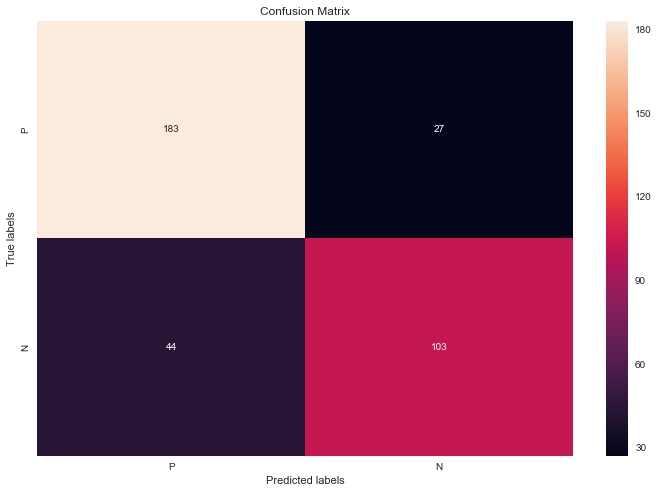

In [120]:
#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
cm = confusion_matrix(y_test, predictions)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="g"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['P', 'N']); 
ax.yaxis.set_ticklabels(['P', 'N']);


In [137]:
scores = precision_recall_f1(predictions,y_test)
print(f"Precision: {scores['Precision']}\n\
Recall: {scores['Recall']}\n\
F1: {scores['F1']}")

Precision: 0.7923076923076923
Recall: 0.7006802721088435
F1: 0.743682310469314
